In [1]:
'''
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Some of the code is modified from "3_mnist_from_scratch from", "docker run -it -p 8888:8888 gcr.io/tensorflow/tensorflow"
'''
from __future__ import print_function

import tensorflow as tf
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from importlib import import_module
from CIFAR_reader import CIFAR_reader # Reference: https://github.com/michael-iuzzolino/CIFAR_reader

In [2]:
cifar = CIFAR_reader(one_hot=True, verbose=True, img_size=32, num_classes=10, augment=False)

Checking for CIFAR data...
Extracting Data...
Unpacking data...
Loading training batch 1 of 5...
Loading training batch 2 of 5...
Loading training batch 3 of 5...
Loading training batch 4 of 5...
Loading training batch 5 of 5...
Loading testing batch 1 of 1...


In [3]:
IMAGE_SIZE = 32
PIXEL_DEPTH = 255
BATCH_SIZE = 10
N_CHANNELS = 3
N_LABELS = 10
SEED = 32

training_data = cifar.train
training_labels = cifar.labels
train_data = training_data['data']
train_labels = training_data['labels']

testing_data = cifar.test
test_data = testing_data['data']
test_data = np.float32(test_data)
test_labels = testing_data['labels']
test_labels = np.float32(test_labels)

N_IMAGE = len(train_data)
train_data = (train_data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
train_data = train_data.reshape(N_IMAGE, IMAGE_SIZE, IMAGE_SIZE, 3)

N_IMAGE = len(test_data)
test_data = (test_data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
test_data = test_data.reshape(N_IMAGE, IMAGE_SIZE, IMAGE_SIZE, 3)

#print("train_data[0]:", train_data[0])
#print("test_data[0]:", test_data[0])

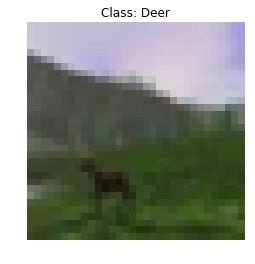

In [4]:
cifar.preview_data(data_set="training")

In [5]:
print (train_data.shape)
print (train_labels.shape)
print (test_data.shape)
print (test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [6]:
VALIDATION_SIZE = 10000

train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_labels = train_labels[VALIDATION_SIZE:]
train_size = len(train_data)
validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_data = np.float32(validation_data)
validation_labels = train_labels[:VALIDATION_SIZE]
validation_size = len(validation_data)

print('train_data.shape', train_data.shape)
print('validation_data.shape', validation_data.shape)
print('train_data size:', train_size)
print('validation_data size:', validation_size)
print('validation_data:', validation_data)
print('validation_labels: ', validation_labels)

train_data.shape (40000, 32, 32, 3)
validation_data.shape (10000, 32, 32, 3)
train_data size: 40000
validation_data size: 10000
validation_data: [[[[-0.36274511 -0.40196079 -0.39803922]
   [-0.39411765 -0.41764706 -0.41764706]
   [-0.40196079 -0.42156863 -0.4254902 ]
   ..., 
   [ 0.01764706  0.00588235  0.00588235]
   [ 0.02156863 -0.0254902  -0.04509804]
   [-0.00588235 -0.04901961 -0.05686275]]

  [[-0.25294119 -0.28431374 -0.30392158]
   [-0.37450981 -0.39411765 -0.41764706]
   [-0.43333334 -0.44901961 -0.46862745]
   ..., 
   [-0.1        -0.12745099 -0.15490197]
   [-0.0882353  -0.1509804  -0.20196079]
   [-0.10784314 -0.1627451  -0.19803922]]

  [[-0.11176471 -0.14313726 -0.17058824]
   [-0.30784315 -0.32352942 -0.35490197]
   [-0.44117647 -0.45294118 -0.48039216]
   ..., 
   [-0.31960785 -0.33137256 -0.34705883]
   [-0.29607844 -0.3392157  -0.36666667]
   [-0.29607844 -0.32745099 -0.3392157 ]]

  ..., 
  [[ 0.1509804   0.14705883  0.17058824]
   [ 0.14313726  0.13921569  0.1509

In [7]:
import tensorflow as tf

train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS))
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, N_LABELS))

validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)

conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, N_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
  tf.truncated_normal([512, N_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[N_LABELS]))

print('Variables Initialized')

Variables Initialized


In [8]:
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    # Max pooling. The kernel size spec ksize also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Model defined')

Model defined


In [9]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
# We'll compute them only once in a while by calling their {eval()} method.
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print('Training computation: logits + cross-entropy loss done')

Training computation: logits + cross-entropy loss done


In [10]:
s = tf.InteractiveSession()
s.as_default()
tf.global_variables_initializer().run()

In [11]:
# Grab the first BATCH_SIZE examples and labels.
batch_data = train_data[:BATCH_SIZE, :, :, :]
batch_labels = train_labels[:BATCH_SIZE]

# This dictionary maps the batch data (as a numpy array) to the
# node in the graph it should be fed to.
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = s.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

print(batch_data.shape)
print(batch_labels.shape)
print('Run graph done.')

(10, 32, 32, 3)
(10, 10)
Run graph done.


In [12]:
print(predictions[0])

[  1.16982765e-01   1.42972870e-03   1.97592890e-05   3.99296312e-07
   8.81408807e-04   1.68743473e-03   1.40850125e-05   8.78815353e-01
   1.66529047e-04   2.52190534e-06]


In [13]:
# The highest probability in the first entry.
print('First prediction', np.argmax(predictions[0]))

# But, predictions is actually a list of BATCH_SIZE probability vectors.
print(predictions.shape)

# So, we'll take the highest probability for each vector.
print('All predictions', np.argmax(predictions, 1))

First prediction 7
(10, 10)
All predictions [7 5 5 1 5 1 6 0 0 7]


In [14]:
print('Batch labels', np.argmax(batch_labels, 1))

Batch labels [1 6 6 8 8 3 4 6 0 6]


In [15]:
correct = np.sum(np.argmax(predictions, 1) == np.argmax(batch_labels, 1))
total = predictions.shape[0]

print(float(correct) / float(total))

confusions = np.zeros([10, 10], np.float32)
bundled = zip(np.argmax(predictions, 1), np.argmax(batch_labels, 1))
for predicted, actual in bundled:
  confusions[predicted, actual] += 1

plt.grid(False)
plt.xticks(np.arange(N_LABELS))
plt.yticks(np.arange(N_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

0.1


In [ ]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

print('Error rate defined')

Error rate defined


In [ ]:
# Train over the first 1/4th of our training set.
steps = train_size // BATCH_SIZE
for step in range(steps):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    # This dictionary maps the batch data (as a numpy array) to the
    # node in the graph it should be fed to.
    feed_dict = {train_data_node: batch_data,
                 train_labels_node: batch_labels}
    # Run the graph and fetch some of the nodes.
    _, l, lr, predictions = s.run(
      [optimizer, loss, learning_rate, train_prediction],
      feed_dict=feed_dict)
    
    # Print out the loss periodically.
    if step % 2 == 0:
        error, _ = error_rate(predictions, batch_labels)
        print('Step %d of %d' % (step, steps))
        print('Mini-batch loss: %.5f Error: %.5f Learning rate: %.5f' % (l, error, lr))
        print('Validation error: %.1f%%' % error_rate(
              validation_prediction.eval(), validation_labels)[0])


Step 0 of 4000
Mini-batch loss: 6.01374 Error: 50.00000 Learning rate: 0.01000
Validation error: 89.8%
Step 2 of 4000
Mini-batch loss: 11.30708 Error: 90.00000 Learning rate: 0.01000
Validation error: 89.1%
Step 4 of 4000
Mini-batch loss: 9.57967 Error: 90.00000 Learning rate: 0.01000
Validation error: 87.6%
Step 6 of 4000
Mini-batch loss: 12.13719 Error: 100.00000 Learning rate: 0.01000
Validation error: 87.5%
Step 8 of 4000
Mini-batch loss: 7.83263 Error: 90.00000 Learning rate: 0.01000
Validation error: 89.1%
Step 10 of 4000
Mini-batch loss: 8.49578 Error: 90.00000 Learning rate: 0.01000
Validation error: 86.7%
Step 12 of 4000
Mini-batch loss: 7.09521 Error: 80.00000 Learning rate: 0.01000
Validation error: 87.1%
Step 14 of 4000
Mini-batch loss: 7.06248 Error: 80.00000 Learning rate: 0.01000
Validation error: 84.8%
Step 16 of 4000
Mini-batch loss: 6.25485 Error: 80.00000 Learning rate: 0.01000
Validation error: 84.7%
Step 18 of 4000
Mini-batch loss: 6.71318 Error: 70.00000 Learning 